In [99]:
import av
import json

# VIDEO_PATH = '../../../tmp/2025-06-10_231949_ABTR8/screen_capture_000000.mp4'
VIDEO_PATH = "/Users/jonathan/Documents/programming/induction/induction-labs/repos/actioncollector/tmp/action_capture/jonathan/2025-06-14_140546_PWLAD/screen_capture_000000.mp4"
container = av.open(VIDEO_PATH)
video_stream = container.streams.video[0]

ACTIONS_PATH = [
    f"/Users/jonathan/Documents/programming/induction/induction-labs/repos/actioncollector/tmp/action_capture/jonathan/2025-06-14_140546_PWLAD/action_capture_{i:06d}.jsonl"
    # f'../../../tmp/2025-06-12_111012_Y7FM5/action_capture_{i:06d}.jsonl'
    for i in range(0, 2)
]

# Load actions (one JSON record per line)
actions = []
for path in ACTIONS_PATH:
    with open(path, 'r') as f:
        for line in f:
            rec = json.loads(line)
            act = rec['action']
            if act["action"] == "mouse_move":
                # timestamp assumed in milliseconds
                actions.append({'timestamp': rec['timestamp'], 'x': act['x'], 'y': act['y']})

In [100]:
def fill_gaps(data, step=0.1):
    new_data = []
    for i in range(len(data) - 1):
        curr = data[i]
        nxt = data[i + 1]
        new_data.append(curr)
        dt = nxt["timestamp"] - curr["timestamp"]
        if dt > step:
            n_steps = int(dt // step)
            for j in range(1, n_steps + 1):
                t = curr["timestamp"] + j * step
                if t < nxt["timestamp"]:
                    ratio = (t - curr["timestamp"]) / dt
                    x = curr["x"] + ratio * (nxt["x"] - curr["x"])
                    y = curr["y"] + ratio * (nxt["y"] - curr["y"])
                    new_data.append({"timestamp": round(t, 10), "x": x, "y": y})
    new_data.append(data[-1])
    return new_data

actions = fill_gaps(actions, step=0.033)
actions.sort(key=lambda a: a['timestamp'])

In [ ]:
import bisect
from PIL import ImageDraw

# just visualize the actions logged vs screen frames
# check that the cursor lines up with the video frames -50ms
OUTPUT_FILE = "output_minus_95.mp4"
output = av.open(OUTPUT_FILE, mode='w')
out_stream = output.add_stream('libx264', rate=video_stream.average_rate)
out_stream.width = video_stream.width
out_stream.height = video_stream.height
out_stream.pix_fmt = 'yuv420p'

previous_time = None

container.seek(0, any_frame=True)  # Reset to the start of the video
_timestamps = [action["timestamp"] for action in actions]
for i, frame in enumerate(container.decode(video=0)):
    # Compute frame time
    pts = frame.pts
    one_frame_time = float(512 * video_stream.time_base)
    # XXX: IMPORTANT: we subtract 512*time_base * 95 to align with the action timestamps
    # this is about 50ms since there's abt 50ms of delay when ffmpeg logs the timestamps
    seconds = float(pts * video_stream.time_base) - one_frame_time * 95

    # Find surrounding actions
    idx = bisect.bisect_left(_timestamps, seconds)
    low_idx = max(idx - 1, 0)
    high_idx = min(idx, len(actions) - 1)

    action_prev = actions[low_idx]
    action_next = actions[high_idx]
    action_prev_time = action_prev['timestamp']
    action_next_time = action_next['timestamp']

    print(f"Frame #{i}: PTS={pts:7d}  ({seconds:.3f} s); "
          f"Prev action at {action_prev_time:.3f}s, Next action at {action_next_time:.3f}s")

    # Linear interpolation (avoid division by zero)
    if action_next_time != action_prev_time:
        t = (seconds - action_prev_time) / (action_next_time - action_prev_time)
    else:
        t = 0.0
    mid_x = action_prev['x'] + (action_next['x'] - action_prev['x']) * t
    mid_y = action_prev['y'] + (action_next['y'] - action_prev['y']) * t

    # Draw overlay on PIL image
    img = frame.to_image().convert('RGB')
    draw = ImageDraw.Draw(img)
    r = 20
    draw.ellipse((mid_x - r, mid_y - r, mid_x + r, mid_y + r), outline='red', width=3)

    # Convert back to VideoFrame
    annotated = av.VideoFrame.from_image(img)

    # Encode and mux
    for packet in out_stream.encode(annotated):
        output.mux(packet)

# Flush encoder
for packet in out_stream.encode():
    output.mux(packet)

output.close()
print(f"Finished writing {OUTPUT_FILE}")

Frame #0: PTS=1749924346649000  (1749924346.600 s); Prev action at 1749924346.594s, Next action at 1749924346.602s
Frame #1: PTS=1749924346701879  (1749924346.653 s); Prev action at 1749924346.602s, Next action at 1749924346.702s
Frame #2: PTS=1749924346728634  (1749924346.680 s); Prev action at 1749924346.602s, Next action at 1749924346.702s
Frame #3: PTS=1749924346753978  (1749924346.705 s); Prev action at 1749924346.702s, Next action at 1749924346.802s
Frame #4: PTS=1749924346792879  (1749924346.744 s); Prev action at 1749924346.702s, Next action at 1749924346.802s
Frame #5: PTS=1749924346829108  (1749924346.780 s); Prev action at 1749924346.702s, Next action at 1749924346.802s
Frame #6: PTS=1749924346854036  (1749924346.805 s); Prev action at 1749924346.802s, Next action at 1749924346.902s
Frame #7: PTS=1749924346892250  (1749924346.844 s); Prev action at 1749924346.802s, Next action at 1749924346.902s
Frame #8: PTS=1749924346929555  (1749924346.881 s); Prev action at 1749924346.80

In [101]:
# plot actions with matplotlib
import matplotlib.pyplot as plt

def plot_actions_normal(actions_timed, frame_cutoff_lines=[], x_range=None):
    x_vals    = [point["x"]    for point in actions_timed]
    y_vals    = [point["y"]    for point in actions_timed]
    time_vals = [point["timestamp"]-actions[0]["timestamp"] for point in actions_timed]

    # Create the scatter plot
    plt.figure(figsize=(12, 4))
    plt.scatter(time_vals, x_vals, marker='o', s=10)
    plt.scatter(time_vals, y_vals, marker='o', s=10)

    for line in frame_cutoff_lines:
        plt.axvline(x=line, color='red', linestyle='--', linewidth=0.5)

    # Label axes
    plt.xlabel("Time")
    plt.ylabel("plot")
    plt.title("Scatter Plot of X vs. Time")

    if x_range is not None:
        plt.xlim(x_range[0], x_range[1])

    # Optional: if time represents seconds and you want grid/dashes
    plt.grid(True, linestyle='--', alpha=0.5)

    # Display
    plt.show()

In [ ]:
# map video frames to actual timestamps
container.seek(0, any_frame=True)  # Reset to the start of the video
video_timestamps = []
for i, frame in enumerate(container.decode(video=0)):
    # Compute frame time
    pts = frame.pts
    one_frame_time = float(512 * video_stream.time_base)
    seconds = float(pts * video_stream.time_base) - one_frame_time * 95
    video_timestamps.append({ "frame_idx": i, "timestamp": seconds })

In [ ]:
# normalize times

reference_timestamp = actions[0]["timestamp"]
# normalize action times
for i in range(len(actions)):
    actions[i]['timestamp'] -= reference_timestamp

# normalize video times
for i in range(len(video_timestamps)):
    video_timestamps[i]["timestamp"] -= reference_timestamp

In [106]:
# filter out video timestamps that are negative
video_timestamps = [vt for vt in video_timestamps if vt["timestamp"] >= 0]

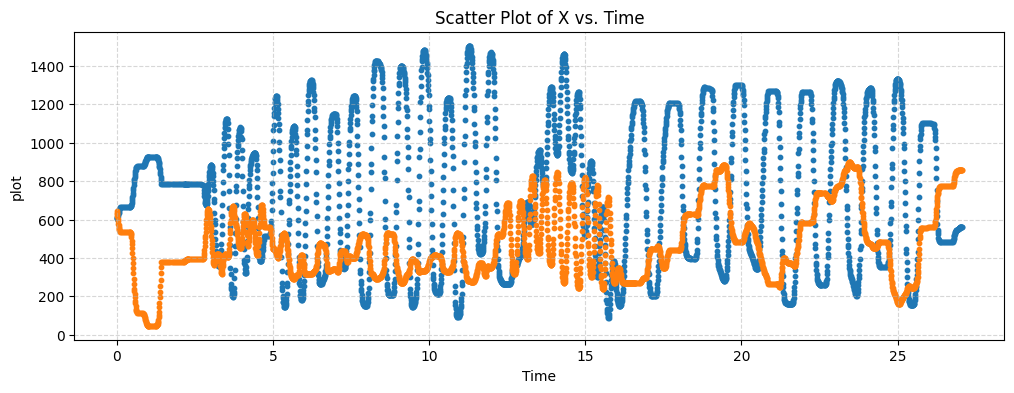

In [107]:
plot_actions_normal(actions)

In [ ]:
import numpy as np

def split_data_linear(data, splits):
    segments = []
    curr_segment = []
    split_idx = 0
    next_split = splits[split_idx] if split_idx < len(splits) else None

    for pt in data:
        # advance to the correct split segment
        while next_split is not None and pt['timestamp'] >= next_split:
            # close out the current segment
            segments.append(curr_segment)
            curr_segment = []
            split_idx += 1
            next_split = splits[split_idx] if split_idx < len(splits) else None

        curr_segment.append(pt)

    # final segment
    segments.append(curr_segment)
    return segments


In [116]:
split_actions_offset = np.arange(0.25, int(actions[-1]["timestamp"]), 0.5)
split_actions = split_data_linear(actions, split_actions_offset)

# for split in split_actions:
#     print(split[0]["timestamp"], split[-1]["timestamp"])

In [119]:
def find_closest_entries_linear(frames, targets):
    results = []
    i_frame = 0
    n = len(frames)
    prev_frame = frames[0] if n > 0 else None
    
    for t in targets:
        # Advance frame pointer until current frame timestamp >= target
        while i_frame < n and frames[i_frame]['timestamp'] < t:
            prev_frame = frames[i_frame]
            i_frame += 1
        
        if i_frame == n:
            # We've exhausted frames; closest is the last one seen
            closest = prev_frame
        elif i_frame == 0:
            # All frames have timestamp >= target; take the first
            closest = frames[0]
        else:
            curr_frame = frames[i_frame]
            # Compare which of prev_frame or curr_frame is closer to t
            if abs(prev_frame['timestamp'] - t) <= abs(curr_frame['timestamp'] - t):
                closest = prev_frame
            else:
                closest = curr_frame
        results.append(closest)
    
    return results

In [ ]:
# basically sample the video frames at 0.25s intervals
def chunk_pairs(lst):
    return [lst[i:i+2] for i in range(0, len(lst), 2)]

chunked_video = chunk_pairs(find_closest_entries_linear(video_timestamps, np.arange(0, int(actions[-1]["timestamp"]), 0.25)))
chunked_video

[[{'frame_idx': 0, 'timestamp': 0.09958481788635254},
  {'frame_idx': 4, 'timestamp': 0.24346399307250977}],
 [{'frame_idx': 12, 'timestamp': 0.510267972946167},
  {'frame_idx': 19, 'timestamp': 0.746243953704834}],
 [{'frame_idx': 27, 'timestamp': 1.0042569637298584},
  {'frame_idx': 34, 'timestamp': 1.2394578456878662}],
 [{'frame_idx': 42, 'timestamp': 1.51078200340271},
  {'frame_idx': 49, 'timestamp': 1.7308378219604492}],
 [{'frame_idx': 57, 'timestamp': 2.010842800140381},
  {'frame_idx': 64, 'timestamp': 2.2353358268737793}],
 [{'frame_idx': 72, 'timestamp': 2.513671875},
  {'frame_idx': 79, 'timestamp': 2.7422518730163574}],
 [{'frame_idx': 87, 'timestamp': 3.0001509189605713},
  {'frame_idx': 94, 'timestamp': 3.233085870742798}],
 [{'frame_idx': 102, 'timestamp': 3.4969229698181152},
  {'frame_idx': 109, 'timestamp': 3.7394189834594727}],
 [{'frame_idx': 117, 'timestamp': 4.000115871429443},
  {'frame_idx': 124, 'timestamp': 4.23339581489563}],
 [{'frame_idx': 132, 'timestamp

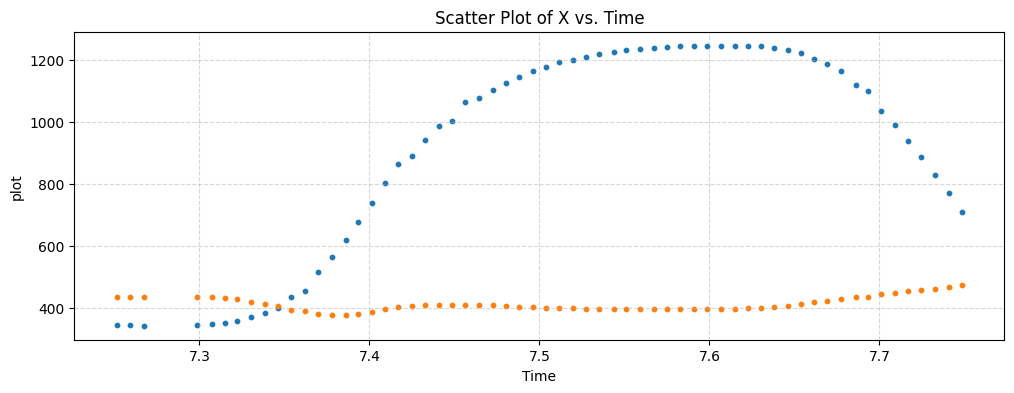

In [110]:
plot_actions_normal(split_actions[15])

In [111]:
import numpy as np
def fit_cubic_endpoints(times, values, *, normalise_y=True):
    """
    Least-squares cubic through (t0,x0) and (tN,xN).

    Parameters
    ----------
    times   : 1-D array-like
        Sample times t[0] … t[-1] (need not be equally spaced).
    values  : 1-D array-like
        Corresponding y values x[0] … x[-1].
    normalise_y : bool, default False
        If True, shift the y-axis so that the curve passes through (t0,0).
        The amount subtracted is returned as `offset`.

    Returns
    -------
    coeffs : ndarray, shape (4,)
        Coefficients [a3, a2, a1, a0] of  
        f(t) = a3·(t-t0)^3 + a2·(t-t0)^2 + a1·(t-t0) + a0
        in the **shifted** time coordinate (t-t0).
        When `normalise_y=True`, `a0` is guaranteed to be 0.
    t0     : float
        Time shift you must subtract from external `t` values before evaluation.
    offset : float
        Vertical shift that was removed (0 if `normalise_y=False`).

    Notes
    -----
    To evaluate in original units:

        y_hat = np.polyval(coeffs, t_raw - t0) + offset
    """
    times   = np.asarray(times,  dtype=float)
    values  = np.asarray(values, dtype=float)

    # --- optional y-axis normalisation ------------------------------------
    offset = values[0] if normalise_y else 0.0
    values_shift = values - offset          # now x0' == 0 if normalised

    # ----------------------------------------------------------------------
    t0, tN = times[0], times[-1]
    T      = tN - t0
    x0, xN = values_shift[0], values_shift[-1]

    if len(times) <= 2:                     # degenerate: just a straight line
        a0 = x0
        a1 = (xN - x0) / T if T else 0.0
        return np.array([0.0, 0.0, a1, a0]), t0, offset

    # Build reduced least-squares system for a3 and a2
    A, b = [], []
    for ti, xi in zip(times[1:-1], values_shift[1:-1]):
        tr    = ti - t0                     # local time
        const = (xN - x0) * (tr / T)        # linear interpolation part
        A.append([tr**3 - T**2*tr,
                  tr**2 - T   *tr])
        b.append(xi - x0 - const)

    A = np.asarray(A)
    b = np.asarray(b)
    a3, a2 = np.linalg.lstsq(A, b, rcond=None)[0]

    # Recover a1 and a0
    a0 = x0                                # 0 if normalised
    a1 = (xN - x0 - a3*T**3 - a2*T**2) / T

    coeffs = np.array([a3, a2, a1, a0])
    return coeffs, t0, offset

In [112]:
split_to_test = split_actions[15]

x_cubic, t0, offset_x = fit_cubic_endpoints([data["timestamp"] for data in split_to_test], [data["x"] for data in split_to_test])
y_cubic, _, offset_y = fit_cubic_endpoints([data["timestamp"] for data in split_to_test], [data["y"] for data in split_to_test])

t_fit_rel = np.linspace(split_to_test[0]["timestamp"]-t0, split_to_test[-1]["timestamp"]-t0)
y_fit = np.polyval(y_cubic, t_fit_rel)
x_fit = np.polyval(x_cubic, t_fit_rel)

cubic_approximation = [
    {"timestamp": t, "x": x, "y": y}
    for t, x, y in zip(t_fit_rel, x_fit, y_fit)
]

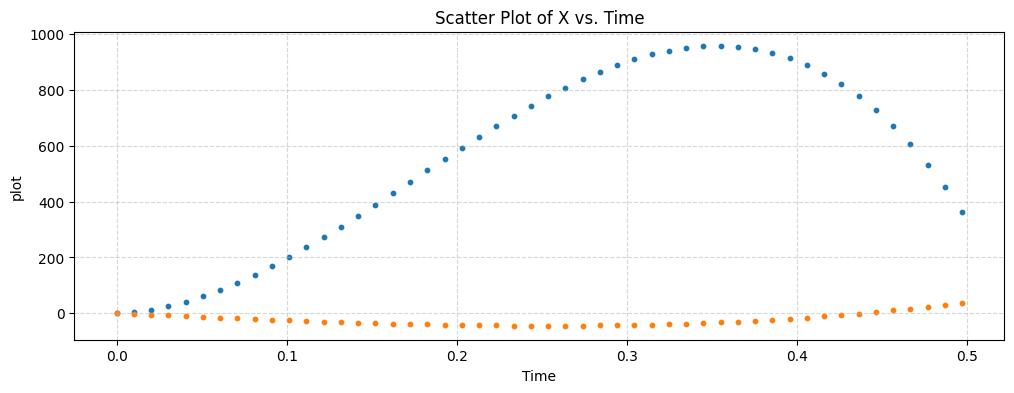

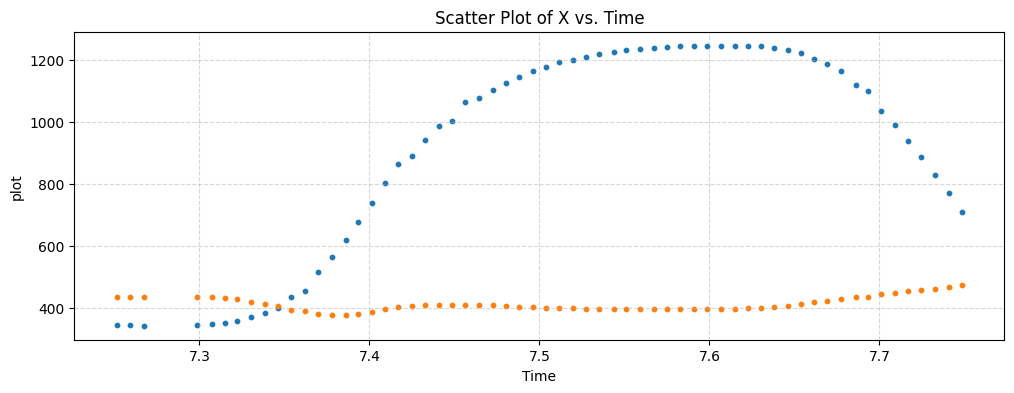

In [113]:
plot_actions_normal(cubic_approximation)
plot_actions_normal(split_to_test)

In [ ]:
# time   0   .25  .5  .75  1   1.25
# T1 T2  A1  A2   B1  B2   C1  C2
#        1 2 3 4 5 6 7 8 9 10 11
#    |______|________|________|
#      Act.  Actions  Actions
#      T0     for A    for B